For this name generator, we implement a birgam character-level language model.

In [98]:
# first import names.csv file and turn into a list of names
import csv

with open('names.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # skip the first row
    with open('names.txt', 'w') as txtfile:
        for i, row in enumerate(csvreader):
            if i < 1000:  # for the first 1000 rows
                name1 = row[1]
                name2 = row[2]
                txtfile.write(name1 + '\n')
                txtfile.write(name2 + '\n') 

In [99]:
# turn all letters to lowercase. this is important because 'A' and 'a' are different characters for the model
with open('names.txt', 'r') as f:
    names = f.read()

with open('names.txt', 'w') as f:
    f.write(names.lower())

In [100]:
# we can now read the names.txt file
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(words[:10])

2000
['olivia', 'liam', 'emma', 'noah', 'charlotte', 'oliver', 'amelia', 'elijah', 'ava', 'james']


The model we will be making predicts the next letter based on the previous 2 letters. First we visualize how we will preprocess the data to make this possible.

In [101]:
# prepare the data for the bigram model

b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

# to visualize we print the first 10 bigrams
print(list(b.items())[:10])

# as you can see, we use < S > to indicate the start of a name and < E > to indicate the end of a name. 
# The number associated counts the amount of times that particular bigram occurs in the data.

[(('<S>', 'o'), 27), (('o', 'l'), 49), (('l', 'i'), 183), (('i', 'v'), 17), (('v', 'i'), 49), (('i', 'a'), 165), (('a', '<E>'), 384), (('<S>', 'l'), 124), (('a', 'm'), 84), (('m', '<E>'), 26)]


In [102]:
# we sort this data from highest to lowest
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 414),
 (('a', '<E>'), 384),
 (('a', 'n'), 328),
 (('e', '<E>'), 286),
 (('<S>', 'a'), 274),
 (('l', 'e'), 227),
 (('e', 'l'), 213),
 (('a', 'r'), 192),
 (('l', 'a'), 185),
 (('l', 'i'), 183),
 (('y', '<E>'), 176),
 (('e', 'n'), 175),
 (('a', 'l'), 171),
 (('<S>', 'm'), 168),
 (('o', 'n'), 167),
 (('i', 'a'), 165),
 (('r', 'i'), 158),
 (('e', 'r'), 156),
 (('n', 'a'), 155),
 (('<S>', 'j'), 149),
 (('<S>', 'k'), 149),
 (('m', 'a'), 143),
 (('i', 'n'), 133),
 (('r', 'a'), 130),
 (('<S>', 'c'), 129),
 (('<S>', 'l'), 124),
 (('r', '<E>'), 122),
 (('<S>', 'e'), 121),
 (('i', 'e'), 118),
 (('<S>', 'r'), 114),
 (('r', 'e'), 107),
 (('h', 'a'), 104),
 (('<S>', 's'), 103),
 (('<S>', 'b'), 103),
 (('l', 'l'), 102),
 (('h', '<E>'), 99),
 (('a', 'y'), 96),
 (('s', '<E>'), 94),
 (('i', 's'), 94),
 (('n', 'n'), 90),
 (('i', '<E>'), 86),
 (('i', 'l'), 85),
 (('d', 'e'), 85),
 (('o', '<E>'), 85),
 (('<S>', 'd'), 85),
 (('a', 'i'), 85),
 (('a', 'm'), 84),
 (('m', 'i'), 84),
 (('n', 'e'),

In [103]:
# from here we import torch and implement a 2D tensor
import torch
N = torch.zeros((27,27), dtype=torch.int32)

In [104]:
# we create a string to integer mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [105]:
# we now create the bigram matrix
for w in words:
  chs = ['.'] + list(w) + ['.'] # add start and end tokens
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

In [106]:
# the start and end token is now represented as follows
print(chs)

['.', 'd', 'a', 'v', 'i', 'a', 'n', '.']


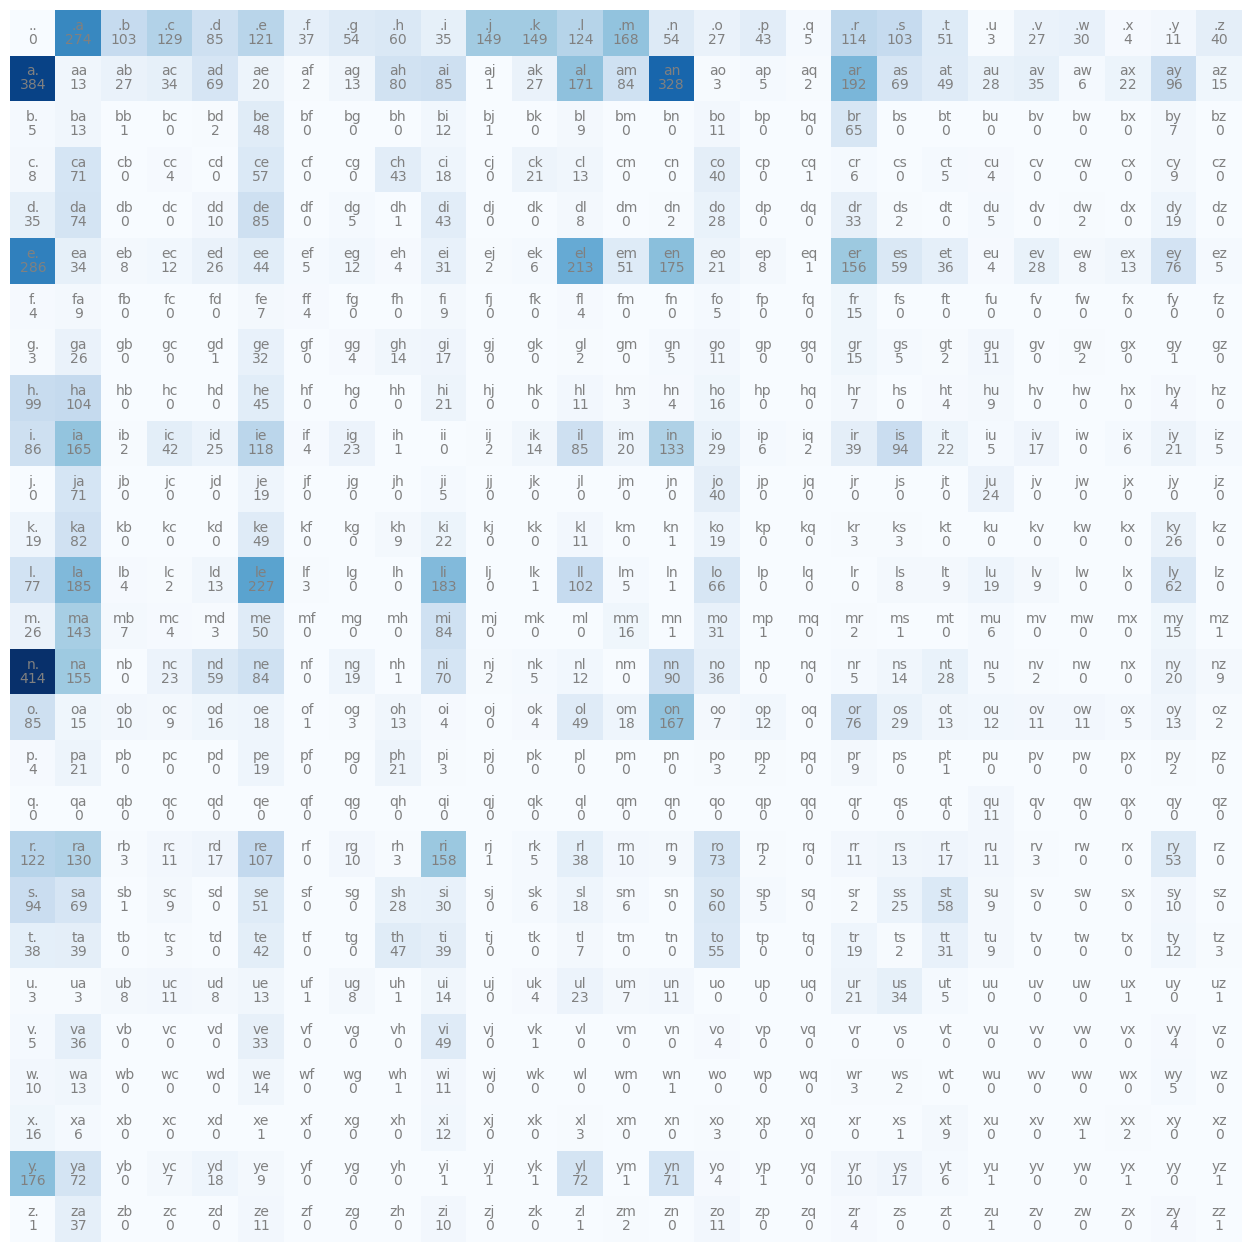

In [107]:
# we can now visualize the bigram matrix using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off'); 
# we see that we can represent <S> and <E> as a single token . 
# .a is the same as <S>a and 
# a. is the same as a<E>

Now we want to be able to sample from the model to generate names. In order to do this, we need to do the following:
1. Sample a letter from the first row via probability distribution 
2. Predict the next letter based on the letter from (1) 
3. Repeat until we get to < E > (end of name)

In [108]:
# first we sample based on the bigram matrix we creted.
N[0] # first row of the matrix

tensor([  0, 274, 103, 129,  85, 121,  37,  54,  60,  35, 149, 149, 124, 168,
         54,  27,  43,   5, 114, 103,  51,   3,  27,  30,   4,  11,  40],
       dtype=torch.int32)

In [109]:
# let's normalize the first row to get the probability of each character combination
p = N[0].float()
p = p/p.sum() # normalize

print(p)
print(p.sum())

tensor([0.0000, 0.1370, 0.0515, 0.0645, 0.0425, 0.0605, 0.0185, 0.0270, 0.0300,
        0.0175, 0.0745, 0.0745, 0.0620, 0.0840, 0.0270, 0.0135, 0.0215, 0.0025,
        0.0570, 0.0515, 0.0255, 0.0015, 0.0135, 0.0150, 0.0020, 0.0055, 0.0200])
tensor(1.)


In [110]:
# now we want to sample from this distribution. We use torch.multinomial which samples from a multinomial distribution
# basically you give it a probability distribution and it gives you back integers based on that distribution
# in essence we are sampling for "letters" based on the probability distribution we created

g = torch.Generator().manual_seed(21342234) # generator makes the results deterministic
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.2278, 0.6446, 0.1276])

In [111]:
# we have roughly 0.23 probability of getting 0, 0.64 probability of getting 1, and 0.13 probability of getting 2
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1])

In [112]:
# now we can get the index of the character using torch.multinomial
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix

0

In [113]:
# now let us perform vectorized normalization of the rows 
# in essence we want to divide all the rows by their respective sums

P = (N+1).float() # add 1 to avoid 0 probabilities
P /= P.sum(1, keepdims=True) # normalize
print(P.shape)
# the 1 parameter indicates that we want to sum across the rows
# keepdim allows for broadcasting

torch.Size([27, 27])


In [114]:
# note that P is a 27x27 matrix and P.sum(1, keepdims=True) is a 27x1 matrix
# by broadcasting semantics this allows division of each row by its sum

In [115]:
# for now we generate 5 names based on the probability from the 0th index of the bigram matrix
# we can compare this result to an "untrained" distribution model where all 27 characters have equal probability

g = torch.Generator().manual_seed(21342234) # generator makes the results deterministic

# "trained" model 
print("Trained model: \n")
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        #p = torch.ones(27) / 27.0
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample from the distribution
        out.append(itos[ix]) # append the character to the output
        if ix == 0:
            break
    print(''.join(out))

# untrained model
print("\nUntrained model: \n")
for i in range(5):
    out = []
    ix = 0
    while True:
        #p = P[ix]
        p = torch.ones(27) / 27.0
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample from the distribution
        out.append(itos[ix]) # append the character to the output
        if ix == 0:
            break
    print(''.join(out))
    
# as you can see the result is a bit more "namelike" as opposed to an 
# untrained model, which would just be a bunch of random letters. 

# the model is just basically trained by how common a pairing occurs 
# and then normalizing the probabilities.

Trained model: 

vay.
a.
hesoh.
amirealas.
rlviasa.

Untrained model: 

oagzwxfk.
oxkmddywdiiuikruifhadiqjiggzlnfwdhbzlggvczeem.
wcntpkvuz.
thvwikbxeczhfvpu.
jvnkwoq.


In [116]:
# now we would like to somehow evaluate this model to see how well it is doing. 
# we can do this by comparing the model's generated names to the actual names in the dataset. 

for w in words[:1]:
    chs = ['.'] + list(w) + ['.'] # add start and end tokens
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob:.4f}')
        
# for an untrained model, the probability of each character combination is 1/27
# any probability higher than 1/27 means that our model is improving

# for a really good model, we expect that the probability is closer to 1

.o: 0.0138
ol: 0.0794
li: 0.1834
iv: 0.0181
vi: 0.3145
ia: 0.1672
a.: 0.2040


In [117]:
# now how can we summarize these probabilities into a single number that measures the quality of this model?
# we are going to use log probabilities to do this

# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [118]:
log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll = }') 
print(f'{nll/n:.4f}') # average negative log likelihood

# the lower the average negative log likelihood, the better the model is doing

log_likelihood=tensor(-32826.1797)
nll = tensor(32826.1797)
2.4061


Now we try to implement a bigram character-level language model in PyTorch through Neural Networks.

In [119]:
# first we create the training set of all the bigram character combinations